Introduction

1.資料及套件讀取
2.利用 apriori() 建立關聯規則
3.視覺化
4.總結
5.Reference

1.資料及套件讀取
這裡是網路上某個顧客購物的公開資料，資料載點如下。

Source: UCI -- Online Retail

https://archive.ics.uci.edu/ml/datasets/online+retail

In [272]:
!pip install mlxtend
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mlxtend.preprocessing import  TransactionEncoder
import csv
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

讀取檔案

In [364]:
df = pd.read_excel('online retail.xlsx')

In [365]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [276]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


查看各國家的購買數量

In [278]:
df["Country"] .value_counts()

Country
United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58


In [279]:
df.shape

(541909, 8)

資料清理

In [281]:
df['Description'] = df['Description'].str.strip()
df['InvoiceNo'] = df['InvoiceNo'].astype('str')
# 去除退貨紀錄
df = df[~df['InvoiceNo'].str.contains('C')]

In [282]:
basket_fr = (df[df['Country'] == "France"]
    .groupby(['InvoiceNo', 'Description'])['Quantity']
    .sum()
    .unstack()
    .reset_index()
    .fillna(0)
    .set_index('InvoiceNo') 
)

basket_fr.head(10) 

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,...,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,YELLOW SHARK HELICOPTER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537468,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


購物籃分析不考慮數量，將數量>0的值全部轉為1

In [284]:
def sum_to_boolean(x):
    if x <= 0:
        return x
    else:
        return 1
basket_fr_final = basket_fr.applymap(sum_to_boolean)
basket_fr_final.head(10)

C:\Users\sarah\AppData\Local\Temp\ipykernel_5888\3045858890.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_fr_final = basket_fr.applymap(sum_to_boolean)


Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,...,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,YELLOW SHARK HELICOPTER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537468,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [285]:
df = basket_fr_final
df.shape

(392, 1563)

2. 利用 apriori 演算法建立關聯規則

apriori 需要設定：

支持度(min support)：「規則」在資料內具有普遍性，也就是這些 A 跟 B 同時出現的機率多少。

信賴度(min confidence)：「規則」要有一定的信心水準，也就是當購買 A 狀態下，也會購買 B 的條件機率。

說明：

RULE: A->B

support = P(A^B) 普遍性

cofidence = P(B|A) 可靠性

lift = P(B|A) / P(B) 有效性

In [288]:
freq_item = apriori(df, min_support = 0.06)

C:\Users\sarah\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [289]:
freq_item.head(10)    #這裡列出了前十名普遍的購買組合

,support,itemsets
0,0.071429,(35)
1,0.096939,(61)
2,0.102041,(64)
3,0.094388,(65)
4,0.068878,(82)
5,0.081633,(103)
6,0.068878,(238)
7,0.066327,(239)
8,0.066327,(253)
9,0.071429,(255)


In [290]:
rules = association_rules(freq_item, metric = "lift", min_threshold = 1)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(64),(61),0.102041,0.096939,0.073980,0.725000,7.478947,1.0,0.064088,3.283859,0.964734,0.591837,0.695480,0.744079
1,(61),(64),0.096939,0.102041,0.073980,0.763158,7.478947,1.0,0.064088,3.791383,0.959283,0.591837,0.736244,0.744079
2,(65),(61),0.094388,0.096939,0.079082,0.837838,8.642959,1.0,0.069932,5.568878,0.976465,0.704545,0.820431,0.826814
3,(61),(65),0.096939,0.094388,0.079082,0.815789,8.642959,1.0,0.069932,4.916181,0.979224,0.704545,0.796590,0.826814
4,(61),(974),0.096939,0.765306,0.084184,0.868421,1.134737,1.0,0.009996,1.783673,0.131484,0.108197,0.439359,0.489211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,"(1268, 974)","(1248, 1267)",0.107143,0.102041,0.081633,0.761905,7.466667,1.0,0.070700,3.771429,0.970000,0.640000,0.734848,0.780952
198,(1248),"(1267, 1268, 974)",0.132653,0.102041,0.081633,0.615385,6.030769,1.0,0.068097,2.334694,0.961765,0.533333,0.571678,0.707692
199,(1267),"(1248, 1268, 974)",0.137755,0.084184,0.081633,0.592593,7.039282,1.0,0.070036,2.247913,0.995007,0.581818,0.555143,0.781145
200,(1268),"(1248, 1267, 974)",0.127551,0.084184,0.081633,0.640000,7.602424,1.0,0.070895,2.543934,0.995431,0.627451,0.606908,0.804848


設定完 min support 及 min confidence，有許多的規則符合我們的要求，但太多的資料對於決策上反而幫助不大，要怎麼挑選出對決策者重要的規則 (熱門 or 冷門 or 特定商品)，都可以利用同樣的概念，去找想要的商品組合

這裡我們避免規則都找出大眾商品，並且想找出可靠性特別高的，及有效性非常高的商品組合，所以特別關注看 confidence / lift > 90 % 相對 support > 40 % 即可

In [292]:
rules_numeric = rules[["support","confidence","lift"]]
rules_numeric.quantile(0.3)   #分析「關聯規則的 30% 分位數」，了解規則分佈狀況，確保規則的品質

support       0.068878
confidence    0.500000
lift          1.143333
Name: 0.3, dtype: float64

In [293]:
rules_numeric = rules[["support","confidence","lift"]]
rules_numeric.quantile(0.9)    #分析「關聯規則的 90% 分位數」，找出最佳的購物規則

support       0.114796
confidence    0.896182
lift          7.602424
Name: 0.9, dtype: float64

如果 lift 在 90% 分位數時仍然 > 1，代表很多規則都是有價值的。
如果 confidence 在 90% 分位數時接近 1，代表這些規則非常可靠。
如果 support 過低，代表這些規則雖然有效，但發生次數少，可能沒那麼重要。

In [295]:
int_rules = rules[(rules["support"]>0.06) & (rules["confidence"]>=0.89) & (rules["lift"]>=7.6)].sort_values(by=["lift"], ascending=False) 

int_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
14,(260),(255),0.068878,0.071429,0.063776,0.925926,12.962963,1.0,0.058856,12.535714,0.991123,0.833333,0.920228,0.909392
15,(255),(260),0.071429,0.068878,0.063776,0.892857,12.962963,1.0,0.058856,8.690476,0.993846,0.833333,0.884932,0.909392
182,"(1248, 1267)",(1268),0.102041,0.127551,0.099490,0.975000,7.644000,1.0,0.086474,34.897959,0.967949,0.764706,0.971345,0.877500
189,"(1248, 1267, 974)",(1268),0.084184,0.127551,0.081633,0.969697,7.602424,1.0,0.070895,28.790816,0.948294,0.627451,0.965267,0.804848


這張表代表的是：

當顧客買了 antecedents，他們會不會買 consequents？
這些規則的可信度 (confidence) 有多高？
這些規則是否真的有價值 (lift > 1)？
這些規則在多少交易中出現 (support)？

總共有 4 條符合我們設定的條件

可以看出是較冷門且兩者產品相關性高(相當類似的產品)

3. 視覺化我們的規則

3.1 scatter plot

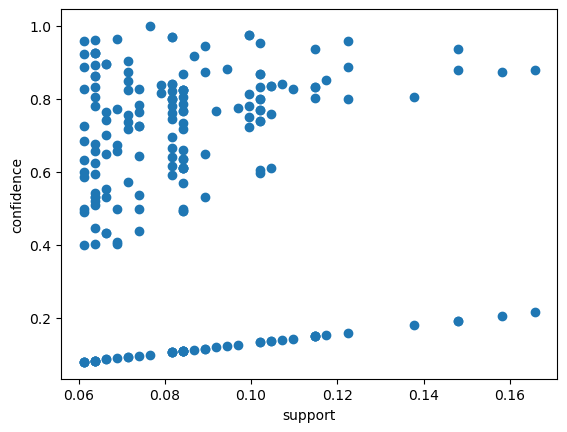

In [299]:
plt.scatter(rules["support"],rules["confidence"])
plt.xlabel("support")
plt.ylabel("confidence")
plt.show()

圖中每個點，代表 rules 中的一條規則：

點的 X 位置 (support)：這條規則在多少交易中出現。
點的 Y 位置 (confidence)：當條件發生時，結果發生的機率。

左上角 (support 低，但 confidence 高)：

代表這些規則發生次數不多 (support 小)，但一旦條件發生，結果發生的機率很高 (confidence 大)。
這通常表示少數商品強關聯，例如：
罕見商品 A 幾乎總是與 B 一起出現，但總交易量不多。
例如「高價商品」或「特定活動產品」，雖然購買人數少，但買了 A 幾乎必定買 B。

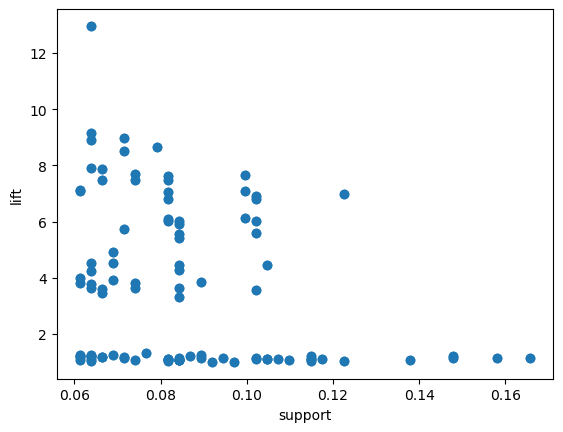

In [302]:
plt.scatter(rules["support"],rules["lift"])
plt.xlabel("support")
plt.ylabel("lift")
plt.show()

大部分規則的 lift 介於 3 到 8，表示這些規則還算有價值，但不一定是最佳的關聯規則。
有些點的 lift 接近 12 或更高，這些規則值得關注：
可能是強烈的購買關聯，例如 「買咖啡幾乎一定會買糖」。
可以考慮促銷這些組合，提高銷售額。

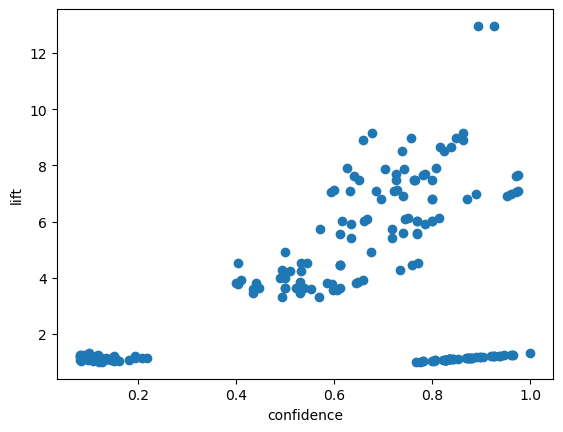

In [304]:
plt.scatter(rules["confidence"],rules["lift"])
plt.xlabel("confidence")
plt.ylabel("lift")
plt.show()

大多數點的 confidence 介於 0.4 到 1 之間，表示這些規則的可信度普遍較高。
lift 的範圍從 1 到 13 以上：
低 lift (≈1-2) → 關聯性不強，這些規則沒有太多影響力。
中等 lift (≈3-8) → 有一定價值，可以進一步分析。
高 lift (>8) → 這些規則最值得關注，代表 A 真的能影響 B 的購買機率。

透過 scatter plot 可以了解這筆資料中的產品組合相關比較數值是如何分布的，也可以看出是否有特別的離群值，可能可以了解離群值是不是特別的商品組合，幫助我們做決策

3.2 網狀圖

利用網狀圖可以更視覺化的了解的同產品之間的關係

In [330]:
new_rules = rules.copy()
new_rules["antecedents"] = rules["antecedents"].apply(lambda x: ','.join(map(str,list(x)))).astype("unicode")
new_rules["consequents"] = rules["consequents"].apply(lambda x: ','.join(map(str,list(x)))).astype("unicode") 

In [368]:
import pandas as pd

# 重新載入原始數據
df_original = pd.read_excel("online retail.xlsx")

# 確保 `StockCode` 和 `Description` 存在
print(df_original.columns)


Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')


In [370]:
# 建立 StockCode -> Description 的對應字典
item_mapping = df_original[['StockCode', 'Description']].drop_duplicates().set_index('StockCode')['Description'].to_dict()

# 檢查前 10 筆對應關係，確認字典內容
print(list(item_mapping.items())[:10])


[('85123A', 'CREAM HANGING HEART T-LIGHT HOLDER'), (71053, 'WHITE MOROCCAN METAL LANTERN'), ('84406B', nan), ('84029G', nan), ('84029E', nan), (22752, 'SET 7 BABUSHKA NESTING BOXES'), (21730, 'GLASS STAR FROSTED T-LIGHT HOLDER'), (22633, nan), (22632, nan), (84879, 'damaged')]


In [372]:
# 移除 Description 為 NaN 的對應關係
item_mapping = {k: v for k, v in item_mapping.items() if pd.notna(v)}

# 再次檢查前 10 筆數據
print(list(item_mapping.items())[:10])


[('85123A', 'CREAM HANGING HEART T-LIGHT HOLDER'), (71053, 'WHITE MOROCCAN METAL LANTERN'), (22752, 'SET 7 BABUSHKA NESTING BOXES'), (21730, 'GLASS STAR FROSTED T-LIGHT HOLDER'), (84879, 'damaged'), (22745, "POPPY'S PLAYHOUSE BEDROOM "), (22748, "POPPY'S PLAYHOUSE KITCHEN"), (22749, 'FELTCRAFT PRINCESS CHARLOTTE DOLL'), (22310, 'IVORY KNITTED MUG COSY '), (84969, 'check')]


In [406]:
print(df.isna().sum())  # 看看有哪些欄位有 NaN


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [408]:
df = df.dropna()  # 刪除所有包含 NaN 值的行


In [410]:
df = df.fillna(0)  # 將 NaN 轉換為 0


In [414]:
df = df.astype(bool)  # 確保數據為布林值


In [416]:
freq_item = apriori(df, min_support=0.06, use_colnames=True)
rules = association_rules(freq_item, metric="lift", min_threshold=1)

print(rules.shape)  # 確保 rules 不是空的
print(rules.head())  # 看前 5 筆資料


(6050, 14)
     antecedents    consequents  antecedent support  consequent support  \
0    (InvoiceNo)    (StockCode)                 1.0                 1.0   
1    (StockCode)    (InvoiceNo)                 1.0                 1.0   
2    (InvoiceNo)  (Description)                 1.0                 1.0   
3  (Description)    (InvoiceNo)                 1.0                 1.0   
4    (InvoiceNo)     (Quantity)                 1.0                 1.0   

   support  confidence  lift  representativity  leverage  conviction  \
0      1.0         1.0   1.0               1.0       0.0         inf   
1      1.0         1.0   1.0               1.0       0.0         inf   
2      1.0         1.0   1.0               1.0       0.0         inf   
3      1.0         1.0   1.0               1.0       0.0         inf   
4      1.0         1.0   1.0               1.0       0.0         inf   

   zhangs_metric  jaccard  certainty  kulczynski  
0            0.0      1.0        0.0         1.0  
1  

C:\Users\sarah\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


In [418]:
import numpy as np

print(rules.isna().sum())  # 檢查 NaN 數量
print((rules == np.inf).sum())  # 檢查無窮大的數量


antecedents           0
consequents           0
antecedent support    0
consequent support    0
support               0
confidence            0
lift                  0
representativity      0
leverage              0
conviction            0
zhangs_metric         0
jaccard               0
certainty             0
kulczynski            0
dtype: int64
antecedents              0
consequents              0
antecedent support       0
consequent support       0
support                  0
confidence               0
lift                     0
representativity         0
leverage                 0
conviction            3991
zhangs_metric            0
jaccard                  0
certainty                0
kulczynski               0
dtype: int64


In [420]:
rules.replace([np.inf, -np.inf], np.nan, inplace=True)  # 把無窮大轉為 NaN
rules.dropna(inplace=True)  # 刪除 NaN


In [422]:
print(rules.head())  # 檢查前 5 筆資料


      antecedents  consequents  antecedent support  consequent support  \
8     (InvoiceNo)  (UnitPrice)                 1.0            0.999902   
20    (StockCode)  (UnitPrice)                 1.0            0.999902   
30  (Description)  (UnitPrice)                 1.0            0.999902   
39     (Quantity)  (UnitPrice)                 1.0            0.999902   
44  (InvoiceDate)  (UnitPrice)                 1.0            0.999902   

     support  confidence  lift  representativity  leverage  conviction  \
8   0.999902    0.999902   1.0               1.0       0.0         1.0   
20  0.999902    0.999902   1.0               1.0       0.0         1.0   
30  0.999902    0.999902   1.0               1.0       0.0         1.0   
39  0.999902    0.999902   1.0               1.0       0.0         1.0   
44  0.999902    0.999902   1.0               1.0       0.0         1.0   

    zhangs_metric   jaccard  certainty  kulczynski  
8             0.0  0.999902        0.0    0.999951  
20  

In [426]:
df_cleaned = df_original[['InvoiceNo', 'StockCode']]
df_cleaned = df_cleaned.drop_duplicates()  # 確保每個商品在訂單內只計算一次


In [433]:
df_cleaned['StockCode'] = df_cleaned['StockCode'].astype(str)

In [435]:
df_boolean = pd.crosstab(df_cleaned['InvoiceNo'], df_cleaned['StockCode'])
df_boolean = df_boolean.astype(bool) 


In [436]:
print(df_boolean.head(10))
print(df_boolean.dtypes)   

StockCode  10002  10080  10120  10123C  10123G  10124A  10124G  10125  10133  \
InvoiceNo                                                                      
536365     False  False  False   False   False   False   False  False  False   
536366     False  False  False   False   False   False   False  False  False   
536367     False  False  False   False   False   False   False  False  False   
536368     False  False  False   False   False   False   False  False  False   
536369     False  False  False   False   False   False   False  False  False   
536370      True  False  False   False   False   False   False  False  False   
536371     False  False  False   False   False   False   False  False  False   
536372     False  False  False   False   False   False   False  False  False   
536373     False  False  False   False   False   False   False  False  False   
536374     False  False  False   False   False   False   False  False  False   

StockCode  10134  ...      M   PADS   P

In [449]:
print(df_cleaned["StockCode"].unique()[:20])  # 取前 20 個 StockCode，確認格式

['71053' '22752' '21730' '22633' '22632' '84879' '22745' '22748' '22749'
 '22310' '84969' '22623' '22622' '21754' '21755' '21777' '48187' '22960'
 '22913' '22912']


In [451]:
df_cleaned = df_cleaned[df_cleaned["StockCode"].astype(str).str.fullmatch(r"\d+")]

In [453]:
print(df_cleaned["StockCode"].unique()[:20])  # 只應該看到純數字

['71053' '22752' '21730' '22633' '22632' '84879' '22745' '22748' '22749'
 '22310' '84969' '22623' '22622' '21754' '21755' '21777' '48187' '22960'
 '22913' '22912']


In [455]:
df_boolean = pd.crosstab(df_cleaned['InvoiceNo'], df_cleaned['StockCode']).astype(bool)


In [457]:
print(df_boolean.sum(axis=0).sort_values(ascending=False).head(20))

StockCode
22423    2172
47566    1706
20725    1608
84879    1468
22720    1462
22197    1442
21212    1334
22383    1306
20727    1295
22457    1266
23203    1249
22386    1231
22960    1220
22469    1214
21931    1201
22411    1187
22961    1174
20728    1173
22382    1170
22086    1170
dtype: int64


In [461]:
from mlxtend.frequent_patterns import apriori, association_rules

# 套用 Apriori 演算法
freq_item = apriori(df_boolean, min_support=0.02, use_colnames=True)

# 建立關聯規則
rules = association_rules(freq_item, metric="lift", min_threshold=1)

# 檢查規則
print(rules.shape)  # 確保 rules 不是空的
print(rules.head())  # 看看前幾筆結果


(74, 14)
  antecedents consequents  antecedent support  consequent support   support  \
0     (20724)     (20719)            0.043158            0.034650  0.020839   
1     (20719)     (20724)            0.034650            0.043158  0.020839   
2     (20724)     (20723)            0.043158            0.030170  0.020141   
3     (20723)     (20724)            0.030170            0.043158  0.020141   
4     (22355)     (20724)            0.036787            0.043158  0.020963   

   confidence       lift  representativity  leverage  conviction  \
0    0.482857  13.935269               1.0  0.019344    1.866699   
1    0.601423  13.935269               1.0  0.019344    2.400647   
2    0.466667  15.468029               1.0  0.018838    1.818432   
3    0.667575  15.468029               1.0  0.018838    2.878368   
4    0.569832  13.203288               1.0  0.019375    2.224346   

   zhangs_metric   jaccard  certainty  kulczynski  
0       0.970108  0.365801   0.464295    0.542140  
1  

In [465]:
print(df_cleaned.columns)


Index(['InvoiceNo', 'StockCode'], dtype='object')


In [467]:
print(df_original.columns)


Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')


In [473]:
item_mapping = df_original[['StockCode', 'Description']].drop_duplicates().set_index('StockCode')['Description'].to_dict()


In [475]:
if 'Description' not in df_cleaned.columns:
    item_mapping = df_original[['StockCode', 'Description']].drop_duplicates().set_index('StockCode')['Description'].to_dict()
else:
    item_mapping = df_cleaned[['StockCode', 'Description']].drop_duplicates().set_index('StockCode')['Description'].to_dict()


In [477]:
print(df_original[['StockCode', 'Description']].head(10))


  StockCode                          Description
0    85123A   WHITE HANGING HEART T-LIGHT HOLDER
1     71053                  WHITE METAL LANTERN
2    84406B       CREAM CUPID HEARTS COAT HANGER
3    84029G  KNITTED UNION FLAG HOT WATER BOTTLE
4    84029E       RED WOOLLY HOTTIE WHITE HEART.
5     22752         SET 7 BABUSHKA NESTING BOXES
6     21730    GLASS STAR FROSTED T-LIGHT HOLDER
7     22633               HAND WARMER UNION JACK
8     22632            HAND WARMER RED POLKA DOT
9     84879        ASSORTED COLOUR BIRD ORNAMENT


In [485]:
# 1️⃣ 確保 StockCode 是字串格式
df_test.index = df_test.index.astype(str)

# 2️⃣ 刪除 Description 為 NaN 的列
df_test = df_test.dropna(subset=['Description'])

# 3️⃣ 轉換為字典
item_mapping = df_test['Description'].to_dict()

# 4️⃣ 確認字典內容
print(len(item_mapping))  # 確保字典長度
print(list(item_mapping.items())[:10])  # 顯示前 10 筆


3958
[('85123A', 'CREAM HANGING HEART T-LIGHT HOLDER'), ('71053', 'WHITE MOROCCAN METAL LANTERN'), ('84406B', '?'), ('84029G', 'KNITTED UNION FLAG HOT WATER BOTTLE'), ('84029E', 'RED WOOLLY HOTTIE WHITE HEART.'), ('22752', 'SET 7 BABUSHKA NESTING BOXES'), ('21730', 'GLASS STAR FROSTED T-LIGHT HOLDER'), ('22633', 'HAND WARMER UNION JACK'), ('22632', 'HAND WARMER RED RETROSPOT'), ('84879', 'damaged')]


In [489]:
# 移除 Description 為 '?' 的行
df_test = df_test[df_test['Description'] != '?']

# 重新建立 item_mapping
item_mapping = df_test['Description'].to_dict()

# 確認處理後的結果
print(len(item_mapping))  # 確保字典長度
print(list(item_mapping.items())[:10])  # 顯示前 10 筆



3958
[('85123A', 'CREAM HANGING HEART T-LIGHT HOLDER'), ('71053', 'WHITE MOROCCAN METAL LANTERN'), ('84406B', 'incorrectly made-thrown away.'), ('84029G', 'KNITTED UNION FLAG HOT WATER BOTTLE'), ('84029E', 'RED WOOLLY HOTTIE WHITE HEART.'), ('22752', 'SET 7 BABUSHKA NESTING BOXES'), ('21730', 'GLASS STAR FROSTED T-LIGHT HOLDER'), ('22633', 'HAND WARMER UNION JACK'), ('22632', 'HAND WARMER RED RETROSPOT'), ('84879', 'damaged')]


In [493]:
print(new_rules["antecedents"].head(10))
print(new_rules["consequents"].head(10))

0    
1    
2    
3    
4    
5    
6    
7    
8    
9    
Name: antecedents, dtype: object
0    
1    
2    
3    
4    
5    
6    
7    
8    
9    
Name: consequents, dtype: object


In [507]:
print(new_rules[["antecedents", "consequents"]].head(10))  # 檢查原始數據
print(new_rules["antecedents"].isna().sum(), new_rules["consequents"].isna().sum())  # 檢查是否有 NaN


  antecedents consequents
0                        
1                        
2                        
3                        
4                        
5                        
6                        
7                        
8                        
9                        
0 0


In [513]:
print(df_boolean.sum().sum())  # 確保至少有一些值是 True


477266


In [ ]:
freq_item = apriori(df_boolean, min_support=0.005, use_colnames=True)
print(freq_item.shape)  # 確保有找到頻繁項目集
